# StackOverflow Tag Prediction with Linear Models

In [1]:
# Import data
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


In [2]:
# Import libraries
from grader import Grader
grader = Grader()
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from ast import literal_eval
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
import collections 
from collections import Counter # counter creates the dictinary of unique words with their frequncy
from scipy import sparse as sp_sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from metrics import roc_auc
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wiseer85/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wiseer85/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Text Preprocessing

In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available).

In [3]:
# Read in data
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
# Describe data
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [5]:
# Create training sets
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [6]:
# Define text preparation function for unstructured data
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    # lowercase text
    text =text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text =  re.sub(BAD_SYMBOLS_RE, '', text)
    # delete stopwords from text
    token_word=word_tokenize(text)
    # filtered_sentence contain all words that are not in stopwords dictionary
    filtered_sentence = [w for w in token_word if not w in STOPWORDS] 
    length_of_string=len(filtered_sentence)
    text_new=""
    for w in filtered_sentence:
        if w!=filtered_sentence[length_of_string-1]:
             text_new=text_new+w+" "
        else:
            text_new=text_new+w
            
    text = text_new
    return text
print("done")

done


In [7]:
# Preform basic tests for text
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

print("done")

done


In [8]:
print(test_text_prepare())

Basic tests are passed.


In [9]:
# Run implementation questions
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [10]:
# Preprocess titles using text_prepare
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [11]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

### 2. WordsTagsCount

Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [12]:
# Use counter to create a dictinary of unique words with their frequncy
print(len(X_train))
words=[]
tag_w=[]
for i in range(0,100000):
    words = words+(re.findall(r'\w+', X_train[i])) 
    tag_w=tag_w+y_train[i]
print("done") 

words_counts = Counter(words) 
tag_counts=Counter(tag_w)

# print(words_counts)
# print(tag_counts)

100000
done


In [13]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = tag_counts
# Dictionary of all words from train corpus with their counts.
words_counts = Counter(words)
# print(tags_counts)
# print(tags_counts.keys())

# v={}
# for i in range(0,10):
# v[most_common_words[i][0]]=i
    
#print(v)
#print(v['javascript'])

In [14]:
# Sort most common words and tags
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,c,php...


## 3. Transforming Text to a Vector

Machine Learning algorithms work with numeric data, and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them: Bag of Words and TF-IDF.

### Bag of Words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [15]:
# Create dictionary of 5000 words
DICT_SIZE = 5000
# Sort by most common word
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000] 

WORDS_TO_INDEX={}
INDEX_TO_WORDS={}

for i in range(0,5000):
    # Extract words from dictionary to index and give values
    WORDS_TO_INDEX[most_common_words[i][0]]=i   
    # Create a list of words corresponding to the index
    INDEX_TO_WORDS[i]=most_common_words[i][0] 

# Define bag of words
def my_bag_of_words(text, words_to_index, dict_size):
    result_vector = np.zeros(dict_size)
    y=text.split(" ")
    for i in range(0,len(y)):
        for key,value in words_to_index.items():
            if y[i]==key:
                result_vector[words_to_index[key]]=result_vector[words_to_index[key]]+1  
    # Number of words taken as features                 
    return result_vector 
print("dsf")

dsf


In [16]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [17]:
print(test_my_bag_of_words())

Basic tests are passed.


In [18]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [19]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count=0
for i in range(0,5000):
    if (row[i]==1):
        non_zero_elements_count=non_zero_elements_count+1
    
print(non_zero_elements_count)

6


### TF-IDF
The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space.

In [20]:
print(X_train[:3])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app']


In [21]:
# Define TF-IDF features
def tfidf_features(X_train, X_val, X_test):
    # Create TF-IDF vectorizer with a proper parameters choice
    tfidf_vectorizer =  TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')#  '(\S+)'  means any no white space
    # Fit the vectorizer on the train set
    X_train=tfidf_vectorizer.fit_transform(X_train)
    # Transform the train, test, and val sets and return the result
    X_val=tfidf_vectorizer.transform(X_val)
    X_test=tfidf_vectorizer.transform(X_test)

    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [22]:
# check whether you have c++ or c# in your vocabulary
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

# print(X_train_tfidf[2])
print('X_test_tfidf ', X_test_tfidf.shape) 
print('X_val_tfidf ',X_val_tfidf.shape)
# print(tfidf_vocab)

X_test_tfidf  (20000, 18026)
X_val_tfidf  (30000, 18026)


## 4. Multi-label Classification

Each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this a logistic regression and onevsrest classifiers are applied. 

In [23]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [24]:
# Define classifier
def train_classifier(X_train, y_train):
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    model=OneVsRestClassifier(LogisticRegression()).fit(X_train,y_train)
    
    return model

print('X_test_tfidf ', X_test_tfidf.shape) 
print('X_val_tfidf ',X_val_tfidf.shape)

X_test_tfidf  (20000, 18026)
X_val_tfidf  (30000, 18026)


In [25]:
# Train classifiers for both transformation vectors
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [26]:
# Predictions
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag) #y_val_predicted_labels_mybag is in the same format of y_train
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [27]:
# Preview results
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf) 
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic adding deleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediate advanced tutorials
True labels:	hibernate,java
Predicted labe

## 5. Evaluation

In [28]:
# Define evaluation function for accuracy, f1 and precision
def print_evaluation_scores(y_val, predicted):
    accuracy=accuracy_score(y_val, predicted)
    f1_score_macro=f1_score(y_val, predicted, average='macro')
    f1_score_micro=f1_score(y_val, predicted, average='micro')
    f1_score_weighted=f1_score(y_val, predicted, average='weighted')
    precision_macro=average_precision_score(y_val, predicted, average='macro')
    precision_micro=average_precision_score(y_val, predicted, average='micro')
    precision_weighted=average_precision_score(y_val, predicted, average='weighted')
    print(accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,precision_macro,precision_micro,precision_weighted)

In [29]:
# Print scores by transformation vector
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.3424 0.49940206496422873 0.6574604103121212 0.6341801141109646 0.33908808925784384 0.463753883551267 0.49427321347014613
Tfidf
0.33363333333333334 0.44420352336445973 0.6403497239021825 0.6128187236796007 0.30075374165910257 0.4552637526997283 0.4835859965133505


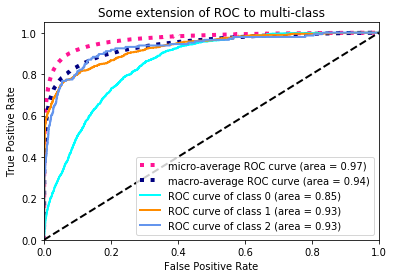

In [30]:
# Plot ROC Curve for bag of words
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

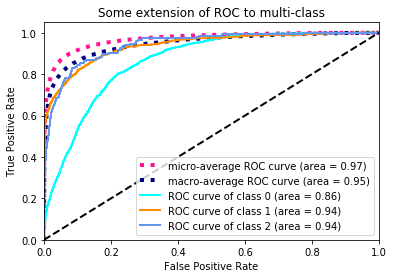

In [31]:
# Plot ROC Curve for TF-IDF
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)